# Adversarial attacks on Neural Networks

This notebook has 6 parts, the last two parts are optionnal and added content :
- Presentation of Attacks on Neural Networks
- Implementation of basic attacks (hands-on)
- Some theory and concepts to explain those basic attacks
- Explaination and Hands-on on black-box attacks and transferability
- Some words about Defense mechanisms
- A fun fact

All the links in the notebook are added in plain text at the end of the notebook in order of apparition. The papers used as source are also linked multiple time in the notebook. Some solution to the exercices and examples are given and loadable from the solutions folder.
Please follow the notebook (and especially the cells) in the order as some content generated are saved and reused throughout the notebook.

Some trainings and tests may take some time (at most 10-15min on the cell), and since I did not have the patience to implement a version for the Colab GPU, there is no escape for those. But they are not that long, and I would highly recommend you to *continue on the following exercises and theory during the computation* as there is a lot to read and do !
(If it takes really too long, advancing in the notebook you will find cells for saving and loading the models and examples : a version is already available with my own tries in the folders, and you can directly load them to escape the long training and generation of examples, but that's not fun...)

PS : Enjoy the work, all the sources and the cool-looking panda :3

## 1 - Attacks on Neural Networks (presentation)

Deep learning models are spreading in applications in the industry and public sectors. In some recent examples we are looking at Convolutional Neural Networks for [self-driving cars](https://blogs.nvidia.com/blog/2019/05/07/self-driving-cars-make-decisions/)\[1\], with the capacity to recognize signs and lights, or in [medical image analysis](https://www.researchgate.net/publication/319535615_Medical_Image_Analysis_using_Convolutional_Neural_Networks_A_Review)\[2\] for detecting diseases such as cancer, or [human face recognition](https://www.researchgate.net/publication/3796546_Human_face_recognition_using_neural_networks)\[3\].

Consequently, Deep Neural Networks become also critical in such systems, and industrials are looking for guarantees and not simple magical black-boxes... You may have found a lot of internship proposals on the subject of Neural Network security whether on the quality of the result, or even on the secrecy of the industry that uses it ! In other words, the development of deep learning applications is limited today because of its low interpretability : we don't know what the model will do and have no guarantees.

But for today we are going to discuss a simple security matter about Neural Networks, which is about the quality of the results. Imagine for a second a self-driving car with such embedded DNN, and imagine for a second that someone outside can modify slightly the images sent to the NN, what would happen ?
An attacker would try to make the image of a red light look like green for the NN, causing an accident. Is it possible ?

Indeed it is, and it's actually quite easy in some situations. But more formally we are going to talk about (and simulate) an attack consisting of modifying as slightly as possible an image so that a Neural Network will wrongly classify it. Let's put it in forms :

<div class="alert alert-warning">
We consider a classification task with data $x \in [0, 1]^d$ and labels $y_{true} \in Z_k$ sampled from a distribution D. We identify a model with an hypothesis $h$ from a space $H$. On input $x$, the model outputs k
class scores $h(x) \in \mathbb{R}$ . The loss function used to train the model, e.g., cross-entropy, is $L(h(x), y)$.

We chose a target model $h \in H$ and an input $(x, y_{true})$. The goal is to find an *adversarial example* $x^{ADV}$ such that $x^{ADV}$ is **close** to x and yet is misclassified by the model. For this case we limit our adversarial examples in the space of $l_{\infty}$ adversaries, such that given a *budget* $\epsilon$, $\parallel x^{ADV} -x \parallel _{\infty} \le \epsilon$.
</div>

This type of adversarial attack is only one type of attack and example, so you can imagine the vastness of the problem to tackle for industrials.
Now let's talk more precisely on the types of attacks : the objective is to find an *adversarial example* close to the original image. In order to do that, we start from the original image and we try to go in the direction of wrong classification. And you see it coming : for some attacks it's just a type of *gradient descent*. The attacks only tries to maximize the loss function around the original image. Yeah that's less impresive !

But let me show you a basic example of the results : 
<img src="img/pandas.png">
from [Explaining and harnessing adversarial examples, Ian J. Goodfellow & al.](https://arxiv.org/pdf/1412.6572.pdf)\[4\]

Not bad eh?

See, there are different types of attacks :
- *White-box attacks* which have access to the model's parameters, vs. *black-box attacks* which don't know anything about the model they are attacking (except maybe about the dataset). 
- *Non-targeted attacks* try to make a misclassification by the model, whereas *Targeted attacks* make a misclassification to a specific target class (red light to green light for instance). 
- And finally *One-shot attacks* only require one step of computation to create an adversarial example, but you can also find *iterative* approaches, which are supposedly better, but we'll see about that...

<div class="alert alert-info">
    Without further do, let's stop <b>talking</b> and do some <b>hackin'</b> !
</div>

## 2 - Basic attacks (hands-on)

Let's start by coding basic attacks.

For now we will use as a target a simple convolutional model from the [pytorch examples](https://github.com/pytorch/examples/blob/master/mnist/main.py)\[5\] as a NN to attack, on the MNIST dataset.

### MNIST

For this part and for the rest on the notebook, all the examples will be applied to the MNIST dataset which you already know.

In [1]:
%matplotlib inline
import itertools
import math
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable

In [2]:
# set batch_size
batch_size = 128

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) ])

train_dataset = torchvision.datasets.MNIST(root='data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='data/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True) # batch_size of 1 for adversarial attack
train_iterator = iter(train_loader)

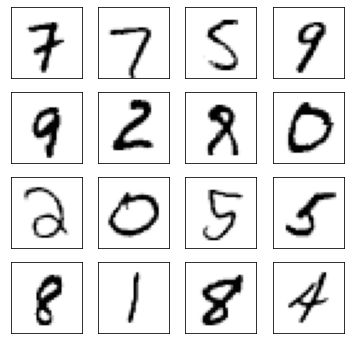

In [3]:
num_test_samples = 16 # number of digits to plot

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# load a batch of training data
images, labels = next(train_iterator)

# show a subpart of it
for k in range(num_test_samples):
    i = k//4
    j = k%4
    ax[i,j].cla()
    ax[i,j].imshow(images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)

Simple CNN network from https://github.com/pytorch/examples/blob/master/mnist/main.py \[5\]

In [4]:
# CNN 
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import pickle

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
lr = 0.01
epochs = 5
log_interval = 100

model = Net()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch, log_interval)
    test(model, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314147
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.059899
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.081585
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.557032
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.661241

Test set: Average loss: 0.3462, Accuracy: 9054/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.522880
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.430228
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.300644
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.422970
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.275029

Test set: Average loss: 0.2175, Accuracy: 9377/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.400047
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.263277
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.235343
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.217581
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.240012

Test set: Average loss: 0.1601, Accuracy: 9506/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.190504
Train Epoch: 4 [12800/60000 (21%)]	Lo

Let's save it in the `models` folder for later use. We store the entire model with all its parameters using `torch.save`, and we can later retrieve the entire model for another training if we want with `torch.load`.

In [6]:
model_file = "models/CNN_model"
torch.save(model, model_file)

Now we will look into the most basic and famous attacking methods. Remember, those methods are optimization functions assimilable to gradient descent and which try to maximize the loss of the NN starting from one classified image.

### Fast Gradient Sign Method

This method create a image-wide perturbation in the direction of the gradient of the loss function. It is a *single-step*, *non-targeted* attack with $\epsilon$ budget regulating the distance from initial image.

$$x_{ADV} = x + \epsilon . sign(\nabla_{x}J(x, y_{true}))$$

In [7]:
# FGSM
def fgsm_attack(data, epsilon, model, target):
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)

    # Calculate the loss (same loss as for training)
    loss = F.nll_loss(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    perturbed_image = data + epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

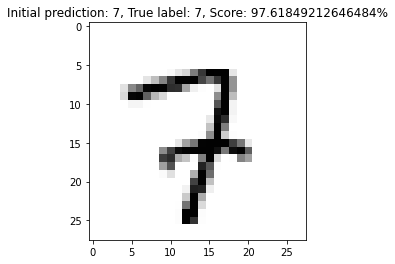

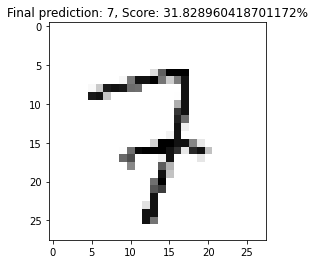

In [8]:
epsilon = 0.05
scorer = torch.nn.Softmax(dim=1)
test_image, test_target = next(iter(test_loader))
output = model(test_image)
init_pred = output.max(1, keepdim=True)[1][0][0]
with torch.no_grad():
    scores = scorer(output)
plt.figure()
plt.imshow(test_image.data.cpu().numpy().reshape(28, 28), cmap='Greys')
plt.title(f"Initial prediction: {init_pred}, True label: {test_target[0]}, Score: {scores[0][init_pred] * 100}%")

perturbed_data = fgsm_attack(test_image, epsilon, model, test_target)
output = model(perturbed_data)
final_pred = output.max(1, keepdim=True)[1][0][0]
with torch.no_grad():
    scores = scorer(output)
plt.figure()
plt.imshow(perturbed_data.data.cpu().numpy().reshape(28, 28), cmap='Greys')
plt.title(f"Final prediction: {final_pred}, Score: {scores[0][final_pred] * 100}%")
plt.show()

### Targeted - FGSM

This method is pretty similar to the basic Fast Gradient Sign Method, except this version is *targeted*, meaning it wants to create an image that the model will classify as a specific class.

$$x_{ADV} = x - \epsilon . sign(\nabla_{x}J(x, y_{target}))$$

If you don't know what target class you should use, try to put the least likely class, $y_{target}=arg min(h(x))$. This is what we call the Single-Step Least-Likely Class Method (Step-LL) by [Adversarial Examples in the Physical World, Kurackin & al.](https://arxiv.org/abs/1607.02533)\[6\].

<div class="alert alert-success">
    <h3>Now it's your turn !</h3>
    Implement this method, and the following, using the formulas. Mind all the parameters in input of the methods !
</div>

In [9]:
# %load solutions/tfgsm_attack.py
def t_fgsm_attack(image, espilon, model, false_target):
    # code HERE
    return image

### Iterative - FGSM

This method is the iterative version of Fast Gradient Sign Method. Remember that we are constrained in the distance to the original image, we therefor have to limit the size of the iterative steps with the parameter $ \alpha = \epsilon/T$.

$$x^{ADV}_0 = x, \space x^{ADV}_{t+1} = x^{ADV}_{t} + \alpha . sign(\nabla_{x}J(x^{ADV}_t, y_{true}))$$

In [10]:
# %load solutions/ifgsm_attack.py
def i_fgsm_attack(image, espilon, T, model, target):
    # code HERE
    return image

### A randomized single-step attack

This method is not famous, but as we will see later on, it has some intresting properties with the random step. It is however a *single-step* attack inspired by the FGSM. $\epsilon$ is our budget and $\alpha \le \epsilon$ is our random step.

First we make a random step : $x' = x + \alpha . sign(\mathcal{N}(\boldsymbol{O}^d, \boldsymbol{I}^d))$

And then we have simply : $x^{ADV} = x' + (\epsilon-\alpha) . sign(\nabla_{x'}J(x', y_{true}))$.

Some people may argue that this is a *two*-steps attack, but don't mess with my nerves.

As I'm very kind, I already implemented this one for you. You're welcome.

In [11]:
# R-FGSM
def r_fgsm_attack(data, epsilon, alpha, model, target):
    new_data = data + alpha * torch.Tensor(np.random.normal(0, 1, size=(1, 1, 28, 28)))
    #new_data = torch.clamp(new_data, 0, 1)
    new_data.requires_grad = True
    
    output = model(new_data)

    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = new_data.grad.data
    
    sign_data_grad = data_grad.sign()
    perturbed_image = new_data + (epsilon - alpha) * sign_data_grad
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

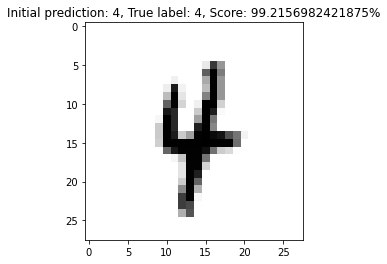

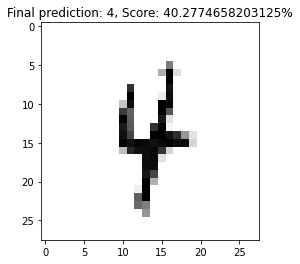

In [12]:
epsilon = 0.05
alpha = 0.02
scorer = torch.nn.Softmax(dim=1)
test_image, test_target = next(iter(test_loader))
output = model(test_image)
init_pred = output.max(1, keepdim=True)[1][0][0]
with torch.no_grad():
    scores = scorer(output)
plt.figure()
plt.imshow(test_image.data.cpu().numpy().reshape(28, 28), cmap='Greys')
plt.title(f"Initial prediction: {init_pred}, True label: {test_target[0]}, Score: {scores[0][init_pred] * 100}%")

perturbed_data = r_fgsm_attack(test_image, epsilon, alpha, model, test_target)
output = model(perturbed_data)
final_pred = output.max(1, keepdim=True)[1][0][0]
with torch.no_grad():
    scores = scorer(output)
plt.figure()
plt.imshow(perturbed_data.data.cpu().numpy().reshape(28, 28), cmap='Greys')
plt.title(f"Final prediction: {final_pred}, Score: {scores[0][final_pred] * 100}%")
plt.show()

### Test on our model

We test the previous methods with this testing function which goes through all test dataset (but skip poorly classified images). It computes for each a perturbed image with the method chosen and return some of the adversarial examples generated and the accuracy on this new images. You can increase the number of adversarial examples in output by increasing the `size_limit` parameter, as we will later do.

In [13]:
# Test on NN
def test_attack( model, test_loader, epsilon, size_limit=5 ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
    
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, model, target)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < size_limit):
                adv_ex = perturbed_data.data.cpu().numpy()
                org = data.data.cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, org) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < size_limit:
                adv_ex = perturbed_data.data.cpu().numpy()
                org = data.data.cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, org) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [14]:
# load the model from saved ones
model = torch.load(model_file)
accuracies = []
examples = []

epsilons = [0.05, 0.1, 0.2, 0.3, 0.5]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_attack(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05	Test Accuracy = 7812 / 10000 = 0.7812
Epsilon: 0.1	Test Accuracy = 7248 / 10000 = 0.7248
Epsilon: 0.2	Test Accuracy = 6014 / 10000 = 0.6014
Epsilon: 0.3	Test Accuracy = 4604 / 10000 = 0.4604
Epsilon: 0.5	Test Accuracy = 1845 / 10000 = 0.1845


Let's save some examples in a pickle file for later use, since it takes a while to compute.

In [15]:
# Create and export 200 adversarial examples for later with epsilon=0.05
model = torch.load(model_file)
acc, ex = test_attack(model, test_loader, 0.05, size_limit=200)

with open('data/pickle/cnn_adv_examples', 'wb') as file:
    pickle.dump(ex, file)

Epsilon: 0.05	Test Accuracy = 7812 / 10000 = 0.7812


We can also plot few of the adversarial examples generated to see the effect of the perturbations, and the impact of epsilon.

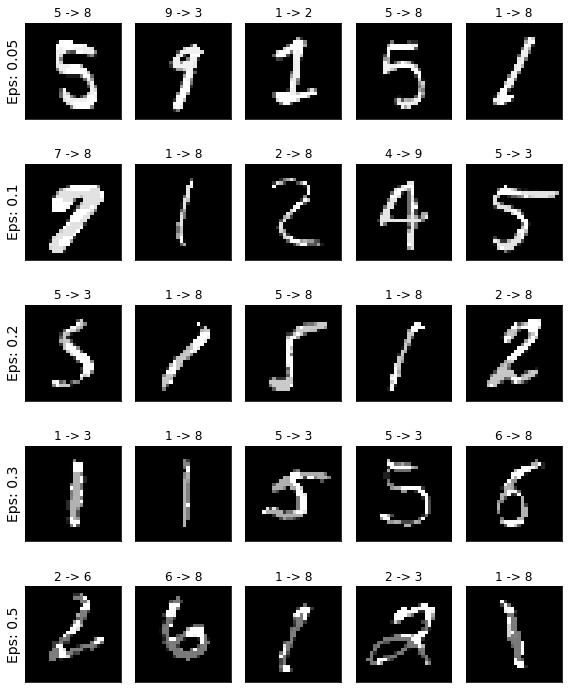

In [17]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex,org_data = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex[0][0], cmap="gray")
plt.tight_layout()
plt.show()

<div class="alert alert-success">
    <h3>Now it's your turn !</h3>
    Try and modify the <b>test_attack</b> function to test another method that you implemented. Make sure to give all the paramenters needed by the method in the <b>test_attack</b> function, and also in the main cell.
</div>

For another, more complex approach to attack using momentum, refer to [Boosting Adversarial Attacks with Momentum, Y.Dong & al.](https://arxiv.org/pdf/1710.06081.pdf)\[7\].

<div class="alert alert-info">
As we can see in this test, we can easily affect the accuracy of the trained model, and the greater epsilon is, the more effective are the attacks. 
However the perturbations are quite visible for some examples, moreover the model was not trained for long (only 5 epochs). We are far from the wonderful example given with the panda. But, I would recommend you after this notebook to try to improve the training of the model for 20 epochs or more, and give a try to the iterative-FGSM attack to see how good this attack can perform in more real cases.

The attacks presented here have obviously some limitations, that we will see in the Defenses part, yet the performance of those attacks is still surprising. Let's try to understand why it works so well.
</div>

## 3 - Why does it work ? (theory-ish)

We know that the given attacks try to look around an original image to find adversarial examples. Let's try to understand why a small perturbation like what we create with those attacks would have such an impact on the output of the NN.

This theory is not formally developed in the sources found, but they give a sense of what is happening, or at least interpretations. However those interpretations may also be false intuitions.

Generally speaking a neural network is simply a highly nonlinear function, from a black box point of view. And the output layer represents a conditional distribution of the label considering the input (and the training of the model). But since we don't want the model to overfit, and to only recognize the training set, we want the model to *generalize* its analysis on the entire space of possible images. For instance we don't want him to only recognize a perfect circle in the center of the image but also a less rounded circle slightly moved from the center.

We want our model to recognize an infinite space (or very dense space) by giving him only a limited number of examples for training. This is like analyzing $\mathbb{R}$ when you only give him $\mathbb{N}$ as training. Therefor the model should generalize information, even in non-local region of the input space (regions that does not contains training examples in their vicinity).
Moreover, we want the model to *locally* generalize the information, so that a slight modification of the image doesn't change the classification. We can call that **smoothness** : imperceptibly tiny perturbations of a given image should not change the underlying class. But we saw with the previous attacks that this is not always the case.

<div class="alert alert-warning">
Since the neural network is highly nonlinear, the input-to-ouput mapping of the model is fairly discontinuous, and the output space around all points is actually not "smooth". We can find adversarial examples close to every point of the input space. In other words, adversarial examples represent low-probability images but which are dense in the input space. 

The ouput space around the original image is not smooth, and to find a different output near the original image we are looking for increased loss (because the loss supposedly translate the distance to correct label). Therefor, intuitively, this means that the loss around training images is not smooth, and the more we increase the loss, the more we have a chance that the output is effectively of a different (wrong) class.
</div>

If $\mathbb{N}$ are the training images, $\mathbb{Q}$ the space of correctly classified images, then irrationnals are the adversarial examples. They have a low probability of appearing, but they are dense in the space of images. That's why it is ineficient to try to create randomly those adversarial examples, but this is actually what we do for usual training by adding transormation of the space for more robustness of the model. We now know that this is not an efficient defense method, and we will look at more advanced defense mechanisms later on.

#### Limits of direct attacks

As we said all the attacks we saw until now are focused on Gradient Descent near the original image. However, as we will see in the Defense mechanisms, this type of attack can be defeated.
Since they use a gradient approximation, the model can naturally have (or learn to have) a non-smooth loss gradient around each points, so that the approximation of the gradient by those linear methods fail.

[Tamèr & al.](https://arxiv.org/pdf/1705.07204.pdf) \[8\] are giving a great view of this, and how it can be used, in the paper *Ensemble adversarial training : attacks and defenses*. Here is an image of this paper to illustrate this.

<img src="img/gradient-masking.png">

This is called the Gradient masking effect : the Loss gradient around the original image have local maxima in different directions, that prevent single-step attacks to find the right direction for increasing the loss. 

And this increasing the loss does not necessarily mean having a different class, the model can actually learn to create Loss small maxima around training point that do not translate in class change (for instance it could change the scores to increase the loss but keep the argmax the same).

This type of defense is less efficient against the iterative attack, which is less sensible to that non-smoothness, but can still be trapped in those local loss maxima.

Remember the R-FGSM attack, with the random step at the beginning ? This is exactly the objective of this random step : get outside of this non-smoothness learnt by the model.

We will see more about that in the Defenses part.

## 4 - About transfers of attacks (mixed)

What we saw until now was actually pretty simple : we attack a model by doing a gradient descent to increase the loss function. But what if we don't have access to the model ?

<div class="alert alert-info">
We can find, for any trained model, adversarial examples with the attacks we developped earlier. But it gets better than this : the adversarial examples we created on a model are actually really robusts, they work on other models as well !
More dramatically, you can even attack model that were trained on a completely different training subset !
</div>

This is called *black-box attack*, and reprensents the event I described at the beginning of someone attacking a self-driving car. 

One major problem about deep learning as I said earlier is the low interpretability of the model. After training we can hardly see what each unit represent or has learnt, and even guarantee what the model will recognize or not.
The study of interpretability of Neural Network is an entirely different and complex subject, so I will not formally present it here. But if you want to get a closer look, I will suggest to start from [Visualizing and Understanding Convolutional Networks, M. Zeiler & R. Fergus](https://arxiv.org/abs/1311.2901) \[9\].

If we are not going to put formal concepts on interpretability, we still are going to use the intuition that we get from this field of study. Especially, we want to understand why adversarial examples generated from a model would work on another. 

Intuitively we think that a model in training is learning to recognize information in the image (for the MNIST example), so that specific layers or units (we don't know which one) are responsible for recognizing a specific feature in the image, and other layers for different features, etc. Therefor we would think that the parameters of the model after training contain some meaning, with the capacity to recognize information. 

If we take a layer, the output vector should give a vector representation of a feature. The direction of the ouput vector should include the meaning of what the unit has learnt, what we call the *semantic*. In other words, we would think that the last layer forms a distinguished basis of the space that is particurlarly suitable to extract semantic information. You could get a better sense of this into [this small explanation](https://www.quora.com/What-does-it-mean-that-Neural-Networks-Disentangle-variation-factors-across-coordinates) \[10\].

<div class="alert alert-warning">
To justify this idea we can look for images that maximize the activation value of a specific feature (an output vector), the result images have supposedly in common the feature that the unit is recognizing, and the ouput vector (the direction) we used would be identify as this specific feature in the output space. 

Formally we look for $x' = arg_{x \in I} max(<\phi(x)|e_i>)$ , where $\phi(x)$ is the layer we consider, and $e_i$ the natural basis vector associated with the i-th hidden unit, and I a set of images from the data distribution that the network was not trained on. The direction $e_i$ intuitively contains the information learnt by the layer, and the x' images found that nearly maximize this projection should share high-level similarities that the layer has recognized.

However in [Intriguing properties of neural networks](https://arxiv.org/pdf/1312.6199.pdf) \[11\], I.Goodfellow & al. show that the maximization of a random projection of the ouput is semantically indistinguishable from the maximization of the ouput projected on the natural basis vector associated with the unit. 
    Meaning that $x' = arg_{x \in I} max(<\phi(x)|v>)$ , where v is a random direction, give the same type of images that share high-level similarities (features). Therefor the direction of the layer doesn't hold the information learnt and our intuition was false.

In other words, the ouput space is not better than a random projection for inspecting the properties of the layer, this suggests that the bulk of semantic information is not included in the individual units, but in the space of activations (the images).
</div>

This explains why adversarial examples are somewhat transferable to other models that were trained on the same or close training set, because the set actually contains this type of hidden information, and the models are just a translation of it in some way.

#### Difference between models

Let's test this transfer of attack between two models that share the same training set. Let's train another simple fully connected model from [here](https://towardsdatascience.com/training-neural-network-from-scratch-using-pytorch-in-just-7-cells-e6e904070a1d) \[12\].

In [18]:
input_size = 784
hidden_layers = [128,64]
output_size = 10
model = nn.Sequential(
    nn.Linear(input_size, hidden_layers[0]),
    nn.ReLU(),
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.ReLU(),
    nn.Linear(hidden_layers[1], output_size),
    nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [19]:
epochs = 8
for e in range(epochs):
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.shape[0], -1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                e, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307805
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.246113
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.177070
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.116590
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.963416
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.925448
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.775309
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.634211
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.396614
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.177643
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.159925
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.967422
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.952745
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.812227
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.706390
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.719453
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.688671
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.793387
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.611425
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.705811
Train Epoch: 4 [0/60

In [20]:
def test_fc(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.shape[0], -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [21]:
test_fc(model, test_loader)


Test set: Average loss: 0.4861, Accuracy: 8701/10000 (87%)



In [22]:
# Save it for later
model_2_file = "models/Fully_connected_model"
torch.save(model, model_2_file)

#### Test of transfer

Now we will try to transfer some adversarial examples generated with the CNN model to the Fully Connected model, and see what are their performance.

In [28]:
# test black-box attacks
cnn = torch.load(model_file)
simple_model = torch.load(model_2_file)
with open('data/pickle/cnn_adv_examples', 'rb') as file:
    cnn_adv_examples = pickle.load(file)

"""
For each example we have the original class, the modified prediction, the adversarial image generated, and the original image.
We will see for the 200 adversarial images from the CNN if they also trick the GAN into misprediction.
"""
def transfer_attack(model, adv_examples, is_fc=True):
    model.eval()
    correct = 0
    adversarial = 0
    modified = 0
    with torch.no_grad():
        for org, mod, adv, data in adv_examples:
            if is_fc:
                # Convert numpy saved data into Tensor
                data = torch.from_numpy(data)
                adv =  torch.from_numpy(adv)
                # Convert the data format for the simple model (784 in input)
                data = data.view(data.shape[0], -1)
                adv = adv.view(data.shape[0], -1)
            if not is_fc:
                data = torch.from_numpy(data.reshape(1, 1, 28, 28))
                adv =  torch.from_numpy(adv.reshape(1, 1, 28, 28))
            output = model(data)
            first_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += first_pred.eq(org).item()
            
            output = model(adv)
            mod_pred = output.argmax(dim=1, keepdim=True)
            adversarial += mod_pred.eq(org).item()
            
            modified += mod_pred.ne(first_pred).item()

    print(f"Adversarial examples {len(adv_examples)}: \n{100. * correct / len(adv_examples)}% accuracy on originals \n{100. * adversarial / len(adv_examples)}% accuracy on adversarials \n-> {100. * modified / len(adv_examples)}% of adversarials led to misclassification")
    
transfer_attack(simple_model, cnn_adv_examples, True)

Adversarial examples 200: 
76.5% accuracy on originals 
19.0% accuracy on adversarials 
-> 70.5% of adversarials led to misclassification


You see that even if the adversarial examples where generated using gradient descent on our Convolutional Network, a third of them successfully attacked our other fully connected model.
To go deeper into the strenght of those adversarial examples, we could apply this test to a complete test set composed of already misclassified images and adversarial examples generated from the CNN on the simple model. We would know what is the impact on the overall accuracy of the simple model.

<div class="alert alert-success">
    <h2>Your turn !</h2>
    Generate adversarial examples for the simple model using the <b>test_attack</b> method from the beginning by completing the following cell. 
    Then test the effectiveness of those adversarial examples on our first CNN. (Remember to save the adversarial examples in a different file for reuse as it take long to generate).
</div>

In [24]:
# %load solutions/test_attack_bis.py
# Test attack on the simple model
def test_attack_bis( model, test_loader, epsilon, size_limit=5 ):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        
        # Modify the format of data so that the simple model can read it
        # Code HERE
        
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue
    
        # Call FGSM Attack or another attack
        perturbed_data = fgsm_attack(data, epsilon, model, target)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < size_limit):
                adv_ex = perturbed_data.data.cpu().numpy()
                org = data.data.cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, org) )
        else:
            if len(adv_examples) < size_limit:
                adv_ex = perturbed_data.data.cpu().numpy()
                org = data.data.cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, org) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [25]:
# %load solutions/fc_adversarial_examples.py
# Generate adversarial examples for the FC model
# Save some of them in a file
filename = 'data/pickle/fc_adv_examples'

# Code HERE

In [26]:
# %load solutions/transfer_fc_attacks.py
# Load FC adversarial examples and test them on the CNN

# Code HERE

Which model is more robust to the attacks ?

#### Difference between training sets

<div class="alert alert-info">
    We could also try a black box attack between two models trained on different training sets from the MNIST example. But since it takes a while to train our two models, and we don't want to get confused with the names, we will not do it here. However if you have some time after the notebook, you can try here to train those models and transfer adversarial examples from one to the other !
</div>

## 5 - (Optionnal) Defenses

Now that we know how main attacks work, we want and try to defend our models to those attacks.
We present here some defense mechanisms described by [Tramèr & al.](https://arxiv.org/pdf/1705.07204.pdf)\[8\].

We already some methods to make NN models more robust via training : using manipulations on the training set such as transformations. However, as we explained earlier in the 3rd part, those methods are similar to randomly or uniformly creating adversarial examples that are inefficients. They are in particular not effective against the type of white-box attacks we saw today.

Yet the models can actually learn to defend themselves against those white-box attacks, by adding adversarial examples in the mix of the training set. In order to ameliorate this *adversarial training*, the percentage of those adversarial examples in the training set, and the time at which those adversarial examples are generated may vary. In their work [Goodfellow & al.](https://arxiv.org/pdf/1312.6199.pdf)\[11\] suggests that the best option is to generate adversarial examples at each step and mix them with the training set in a stable proportion.

The theory behind adversarial training is actually fascinating, I highly recommend to take a look at [the paper from Tramèr & al.](https://arxiv.org/pdf/1705.07204.pdf)\[8\].
For instance, the adversarial training enables the model to train no on the adversarial examples, but actually make the attack itself perform worse overall !

This is in particular due to the limits of attacks, that we presented shortly in the *Why it works* section.

<div class="alert alert-warning">
To make it more formal : we take the notation from Tramèr & al. 
$$h^{*} = argmin_{h \in H} \mathbb{E}_{(x, y_{true} \sim D)}[max_{\| x^{ADV}-x\|_{\infty} \le \epsilon} L(h(x^{ADV}), y_{true})]$$
</div>

The ideally trained model $h^*$ is the model that minimizes the risk of adversarial examples, i.e. minimizes in mean the loss of generated adversarial examples.
You there are two optimization problems, quite like the GAN : the attack is generating adversarial examples that maximize the loss around the original images from D (the training set for instance), and the model is learning to minimize the mean of this created loss. This may remind you of the GAN with the Generator creating adverarial fake images, and the discriminator trying to discern which is which.

However, Tramèr & al. point out that by using standard attacks like single-step FGSMs we do not sufficiently approach the maximization problem inside the bracket, meaning the attack is far from the maximum of loss we could create around the images. Therefor the adversarial training is less effective and even reach a degenerate solution of this optimization problem. 

To tackle this limitation, they propose an ensemble adversarial training, using the black-box transferability of adversarial examples instead of generating them directly on the model. This ensemble training method (ensemble because it uses different models for generation of adversarial examples) is better in the sens that the model has no effect on the strength of the attack : it cannot limit the attack with unsmooth gradient anymore, since the attacks are generated on other static models. Moreover this method supposedly train the model against black-box attacks (or at least it trains it better than usual adversarial training).

They formulate a theorem that state this capacity of the trained model to resist to future black-box attacks if the new adversary A∗ is not “much stronger” than the adversaries used for training.

As you can see this is not much convincing for an industrial who wishes for guarantees. Not only we cannot guarantee the robustness of the model to black-box attacks, but this just for the $l_{\infty}$ bounded adversarial examples ! They are a lot of other classes of adversaries. By reducing the dimension (for example for the MNIST problem with lower dimension than other ImageNet-scale tasks) we can reach some kind of guarantees, but still limited to the adversaries met in training, whereas for higher dimensions the guarantees seem out of reach.

There are other type of defense mechanisms like high-level Denoiser methods based on DUNET, which try to dimish the amplification of the perturbation throughout the layers of the model. They are different types of Denoiser, a small description is given in [this article on medium.com](https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7) \[13\], and you can find an implementation of such denoiser on this [GitHub repository](https://github.com/lfz/Guided-Denoise) \[14\].

[Goodfellow & al.](https://arxiv.org/pdf/1312.6199.pdf) \[11\] present a spectral analysis of the stability of model accross layers, which can be used to give bounds to the adversarial examples' perturbations effects.

In conclusion there is still a lot of work to do in the subject of attacks and defenses mechanisms, as well as formal guarantees and interpretability of neural networks.

## 6 - Infinity War 2 (fun-fact)

With all this attack and defense mechanisms, we are entering a similar research on cybersecurity world, where people are trying to attack the best defenses, and defend against the best attacks.

The most famous attacks and defenses are all presented in the [NISP Competition of 2017](https://www.kaggle.com/google-brain/nips17-adversarial-learning-final-results) \[15\], which is cited by almost the ressources I gave in this notebook. This competition establishes a ranking of best attacks and defenses. Have a look, you can event try and complete this notebook by implementing them (the boosted attack with momentum for instance is just at your reach !).

## Sources

I hope you had fun with this notebook hacking some simple model of Neural Network, and that you understood some of the principles behind attacks and defenses.

Here is the list of all the links and ressources of this notebook in order of appearance !

\[1\] https://blogs.nvidia.com/blog/2019/05/07/self-driving-cars-make-decisions/

\[2\] https://www.researchgate.net/publication/319535615_Medical_Image_Analysis_using_Convolutional_Neural_Networks_A_Review

\[3\] https://www.researchgate.net/publication/3796546_Human_face_recognition_using_neural_networks

\[4\] [Explaining and harnessing adversarial examples, Ian J. Goodfellow & al.](https://arxiv.org/pdf/1412.6572.pdf)

\[5\] [PyTorch examples for MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

\[6\] [Adversarial Examples in the Physical World, Kurackin & al.](https://arxiv.org/abs/1607.02533)

\[7\] [Boosting Adversarial Attacks with Momentum, Y.Dong & al.](https://arxiv.org/pdf/1710.06081.pdf)

\[8\] [Ensemble adversarial training : attacks and defenses, Tamèr & al.](https://arxiv.org/pdf/1705.07204.pdf)

\[9\] [Visualizing and Understanding Convolutional Networks, M. Zeiler & R. Fergus](https://arxiv.org/abs/1311.2901)

\[10\] [Small explanation on semantic information extraction by NN](https://www.quora.com/What-does-it-mean-that-Neural-Networks-Disentangle-variation-factors-across-coordinates)

\[11\] [Intriguing properties of neural networks, I.Goodfellow & al.](https://arxiv.org/pdf/1312.6199.pdf) the main source for the notebook

\[12\] [A simple fully connected network for MNIST](https://towardsdatascience.com/training-neural-network-from-scratch-using-pytorch-in-just-7-cells-e6e904070a1d)

\[13\] [Medium article on Adversarial attacks and Defences](https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7)

\[14\] [GitHub repository of a High-level Denoiser](https://github.com/lfz/Guided-Denoise)

\[15\] [The NISP Competition of 2017](https://www.kaggle.com/google-brain/nips17-adversarial-learning-final-results)